# Семинар 7. QC



## Домашнее задание

## Задание 1

Протестируйте написанный нами EM-алгоритм на устойчивость к параметрам изначальной инициализации.

In [58]:
import scanpy as sc
import seaborn as sns
import scanpy.external as sce
import anndata2ri
import rpy2.robjects as ro
import scipy.stats as stats
from scipy.special import logsumexp
anndata2ri.activate()
%load_ext rpy2.ipython

sc.set_figure_params(dpi=150)
sns.set_style("ticks")

# демонстрационный датасет от 10x genomics
adata = sc.read_10x_h5("10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5")
adata.var_names_make_unique() #когда Gene Symbol повторяется, то к ним добавляется постфикс

min_umi = 10
adata = adata[adata.X.sum(axis=1).A.T[0] >= min_umi]

X = np.log(adata.X.sum(axis=1).A.T[0])

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/silenos/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Из параметров начальной инициализации мы можем изменить априрорные вероятности, начальные средние и нчальные дисперсии.

Для удобства создаю функцию, которая осуществляет рандомизацию желаемых параметров

In [191]:
def initial_params(phi_param = "std", mu = "std" , sigma = "std"):
    expected_cells = np.random.random() if phi_param == "random" else 10000 / len(adata)

    params = {
      "phi_real" : expected_cells,
      "phi_empty" : (1 - expected_cells) / 2,
      "mu_real" : np.log(10000) if mu == "std" else np.log(np.random.randint(40000)),
      "mu_int" : np.log(500) if mu == "std" else np.log(np.random.randint(40000)),
      "mu_empty" : np.log(10) if mu == "std" else np.log(np.random.randint(40000)),
      "sigma_real" : 1 if sigma == "std" else np.random.randint(1,10),
      "sigma_int" : 1 if sigma == "std" else np.random.randint(1,10), 
      "sigma_empty" : 1 if sigma == "std" else np.random.randint(1,10)
    }

    for param in params:
        print(f"{param}: {params[param]}")

    params_start = params.copy()

    start_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
    start_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
    start_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)

    ax = sns.kdeplot(start_real)
    ax = sns.kdeplot(start_empty)
    ax = sns.kdeplot(start_int)
    ax.set_title("Start position")
    
    return params

In [204]:
def E_step(X, params, draw=False):
    LogProb = np.log([
      stats.norm(params["mu_empty"], params["sigma_empty"]).pdf(X),
      stats.norm(params["mu_int"], params["sigma_int"]).pdf(X), 
      stats.norm(params["mu_real"], params["sigma_real"]).pdf(X)
    ])
    logPrior = np.log([params["phi_empty"], 1 - params["phi_real"] - params["phi_empty"], params["phi_real"]])
    logNum = logPrior + LogProb.T
    RealSoftMax = logsumexp(logNum, axis=1)
    probabilities = np.exp(logNum - np.array([RealSoftMax]).T)
    return RealSoftMax, probabilities

def M_step(X, params, probabilities):
    prob_empty = probabilities[:, 0]
    prob_int = probabilities[:, 1]
    prob_real = probabilities[:, 2]

    # Вычисление новых значений
    phi_empty = prob_empty.sum() / len(X)
    phi_real = prob_real.sum() / len(X)

    mu_empty = prob_empty.dot(X) / np.sum(prob_empty)
    mu_int = prob_int.dot(X) / np.sum(prob_int)
    mu_real = prob_real.dot(X) / np.sum(prob_real)

    sigma_empty = (np.sum(prob_empty * (X - mu_empty) ** 2) / np.sum(prob_empty)) ** 0.5
    sigma_int = (np.sum(prob_int * (X - mu_int) ** 2) / np.sum(prob_int)) ** 0.5
    sigma_real = (np.sum(prob_real * (X - mu_real) ** 2) / np.sum(prob_real)) ** 0.5

    return {
      "phi_empty" : phi_empty,
      "phi_real" : phi_real,
      "mu_empty" : mu_empty,
      "mu_int" : mu_int,
      "mu_real" : mu_real,
      "sigma_empty": sigma_empty,
      "sigma_int": sigma_int,
      "sigma_real": sigma_real
    }

def run_EM(X, params):
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params)
        avg_allprob.append(np.mean(probabilities))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)

    allprob, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    
    return forecasts, probabilities, avg_allprob, params

In [205]:
def plot_final(params):
    final_real = stats.norm(params["mu_real"], params["sigma_real"]).rvs(size=1000)
    final_int = stats.norm(params["mu_int"], params["sigma_int"]).rvs(size=1000)
    final_empty = stats.norm(params["mu_empty"], params["sigma_empty"]).rvs(size=1000)
    
    fig, axis = plt.subplots()
    sns.kdeplot(final_empty, ax = axis)
    sns.kdeplot(final_int, ax = axis)
    sns.kdeplot(final_real, ax = axis)
    axis.set_title("Final position")

Возьмём сходимость, полученную при эмпирическом оценивании параметров, за референс

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 1
sigma_int: 1
sigma_empty: 1


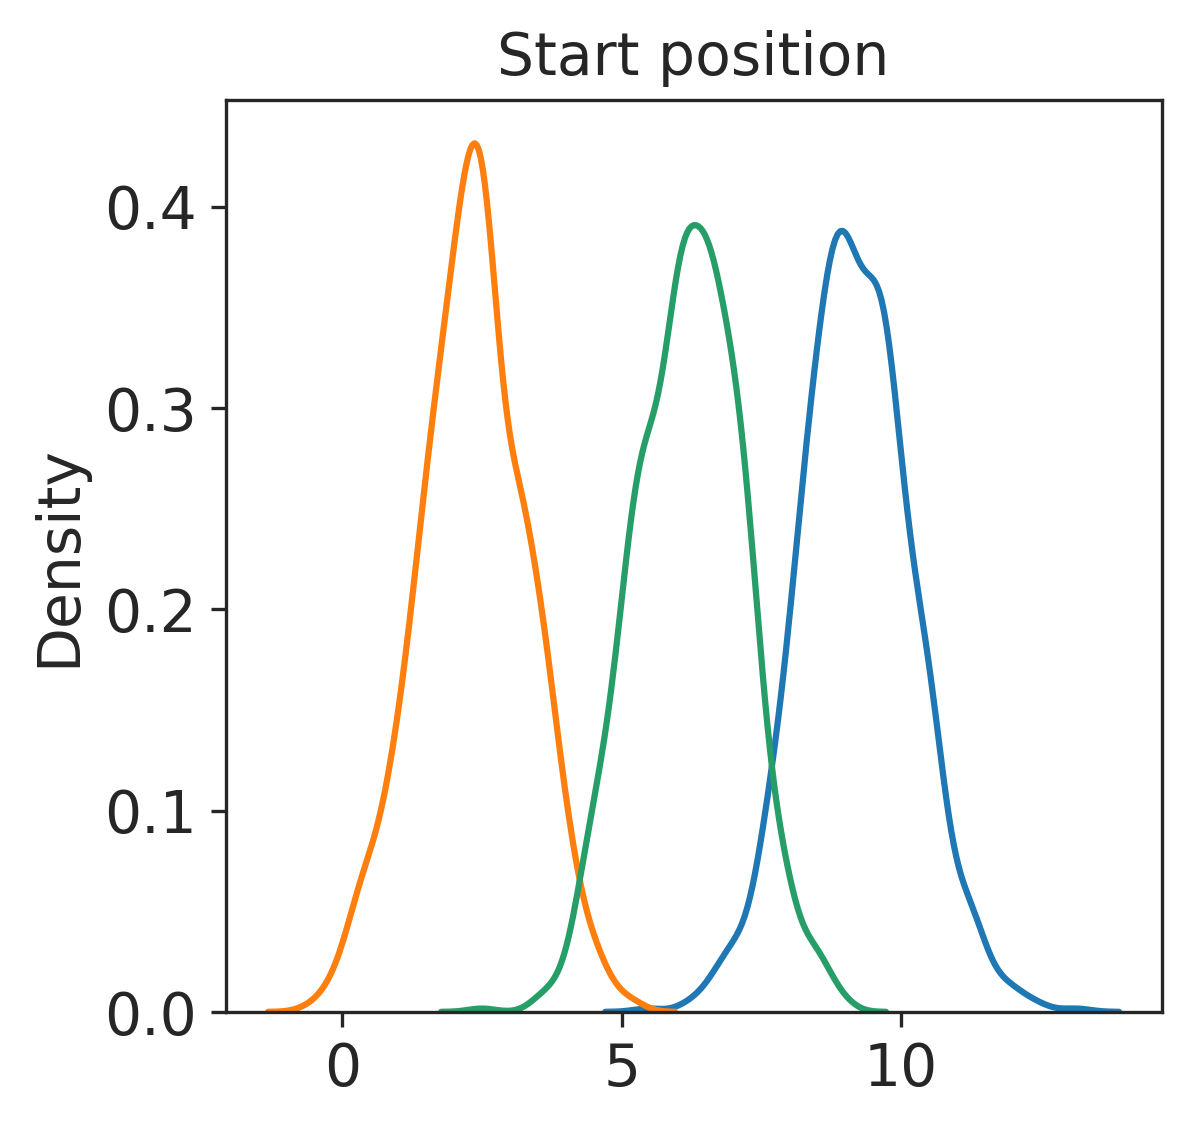

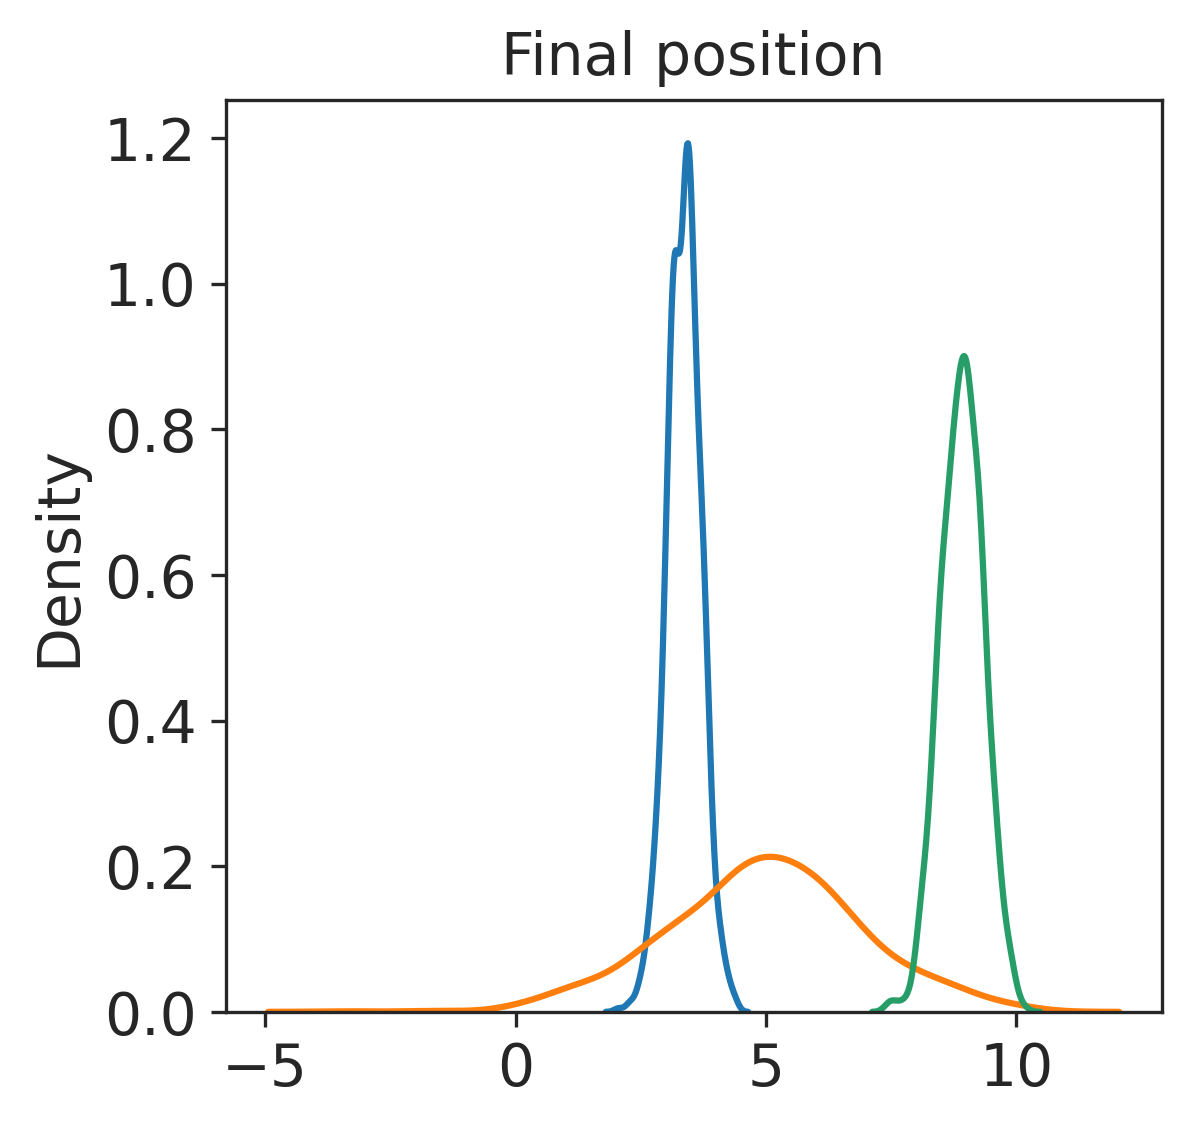

In [207]:
params = initial_params(phi_param = "std", mu = "std", sigma = "std")
pred, prob, avg_allprob, params = run_EM(X, params)
plot_final(params)

Изменяем априрорные вероятности

phi_real: 0.5313977505704897
phi_empty: 0.23430112471475517
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 1
sigma_int: 1
sigma_empty: 1


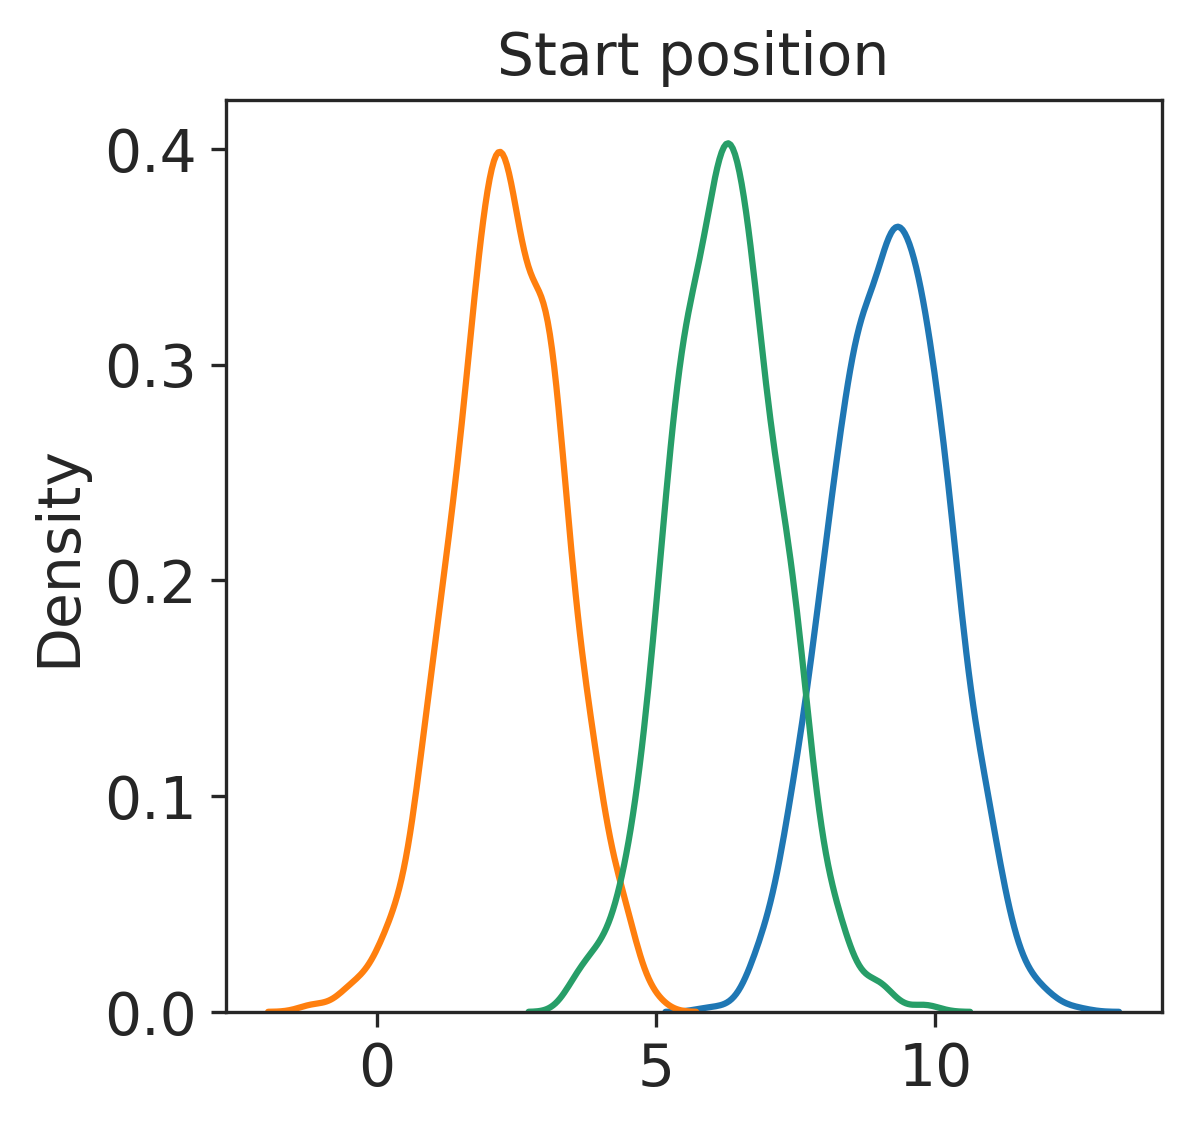

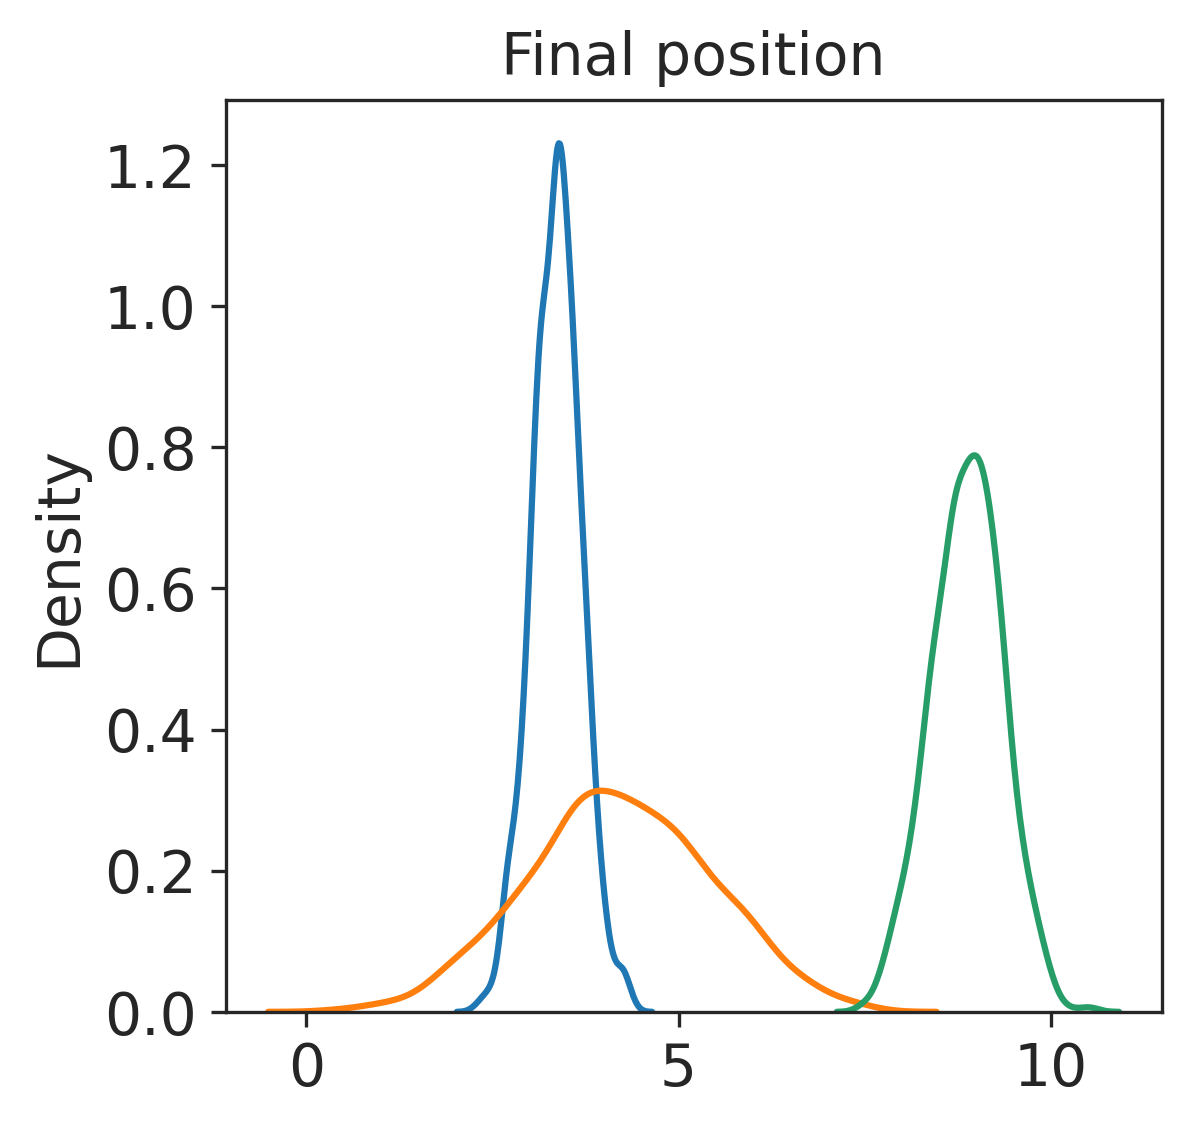

In [208]:
params = initial_params(phi_param = "random", mu = "std", sigma = "std")
pred, prob, avg_allprob, params = run_EM(X, params)
plot_final(params)

Не так плохо, но хуже, чем при референсных значениях

Рандомизируем начальные средние

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.99897953399535
mu_int: 10.151323716440709
mu_empty: 8.544419177669829
sigma_real: 1
sigma_int: 1
sigma_empty: 1


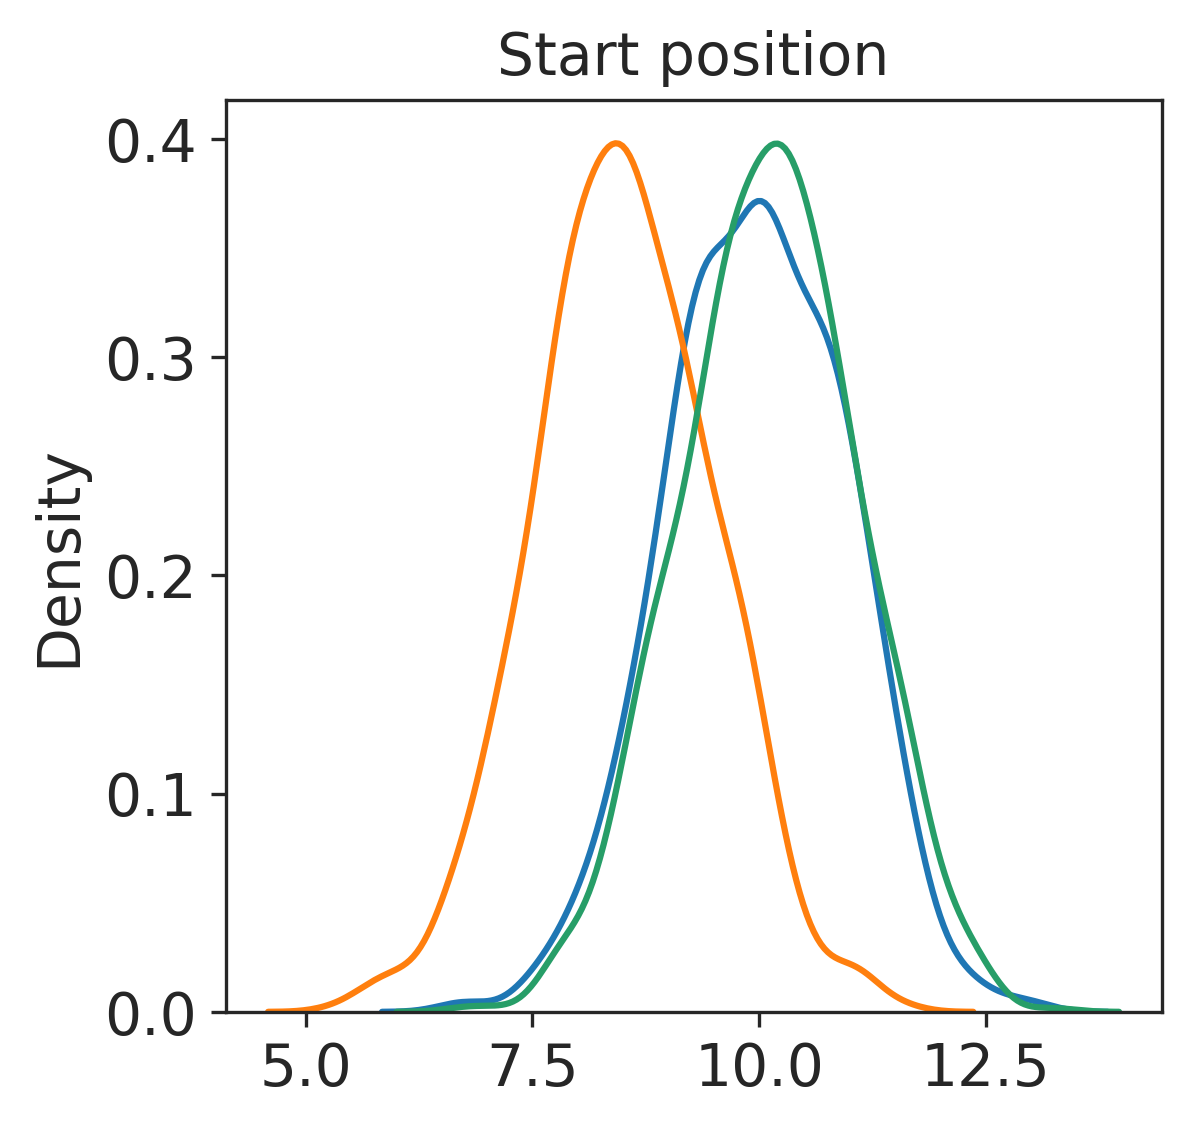

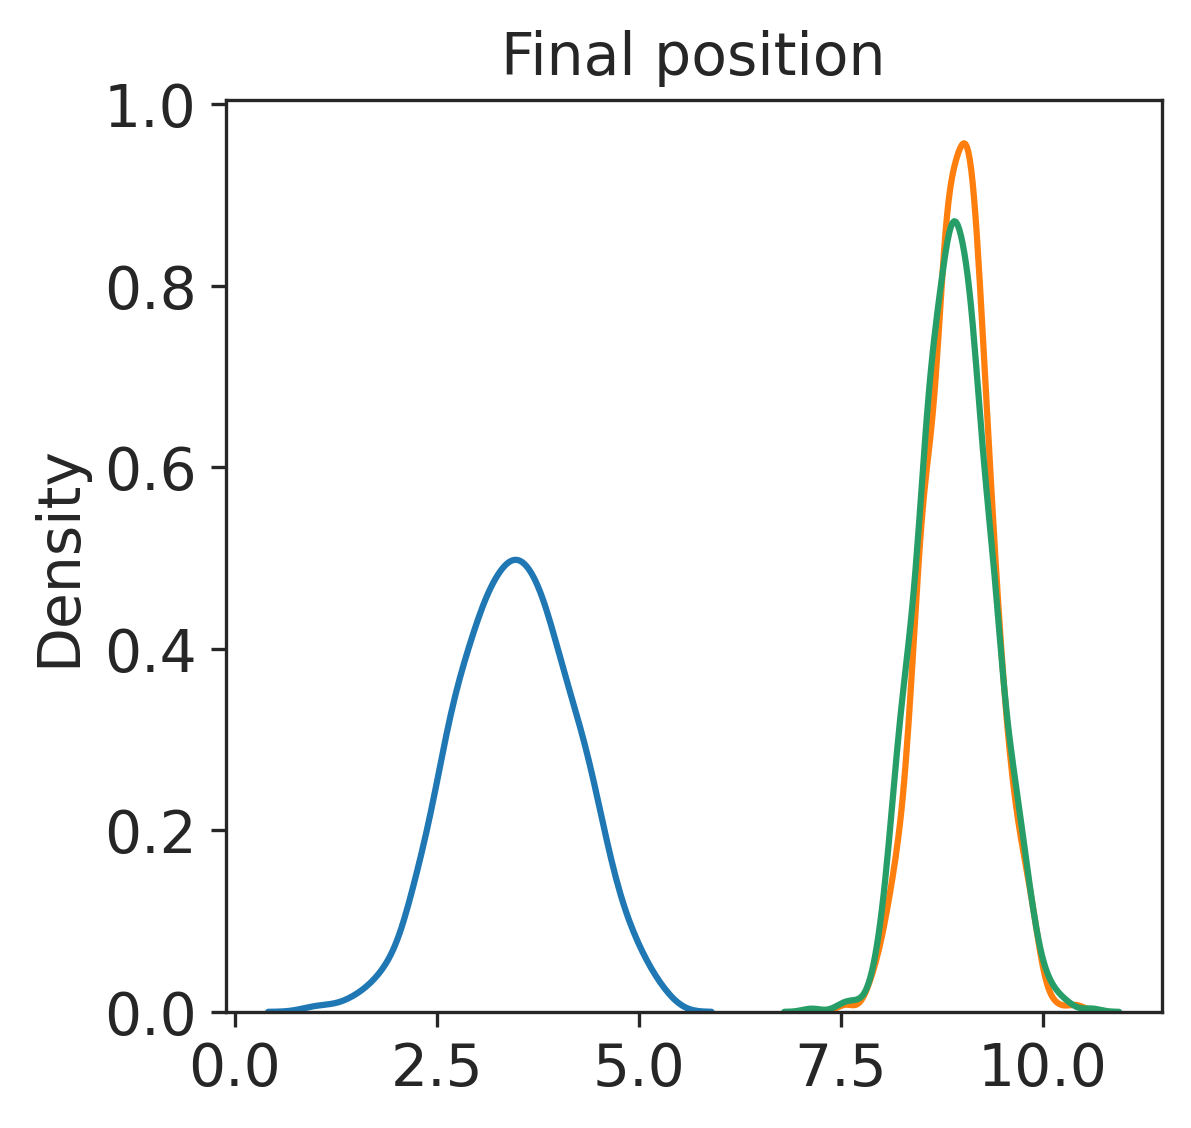

In [210]:
params = initial_params(phi_param = "std", mu = "random", sigma = "std")
pred, prob, avg_allprob, params = run_EM(X, params)
plot_final(params)

Видим, что сходимость не дала благоприятного результата

А теперь рандомизируем дисперсии

phi_real: 0.11704941826439122
phi_empty: 0.4414752908678044
mu_real: 9.210340371976184
mu_int: 6.214608098422191
mu_empty: 2.302585092994046
sigma_real: 6
sigma_int: 5
sigma_empty: 6


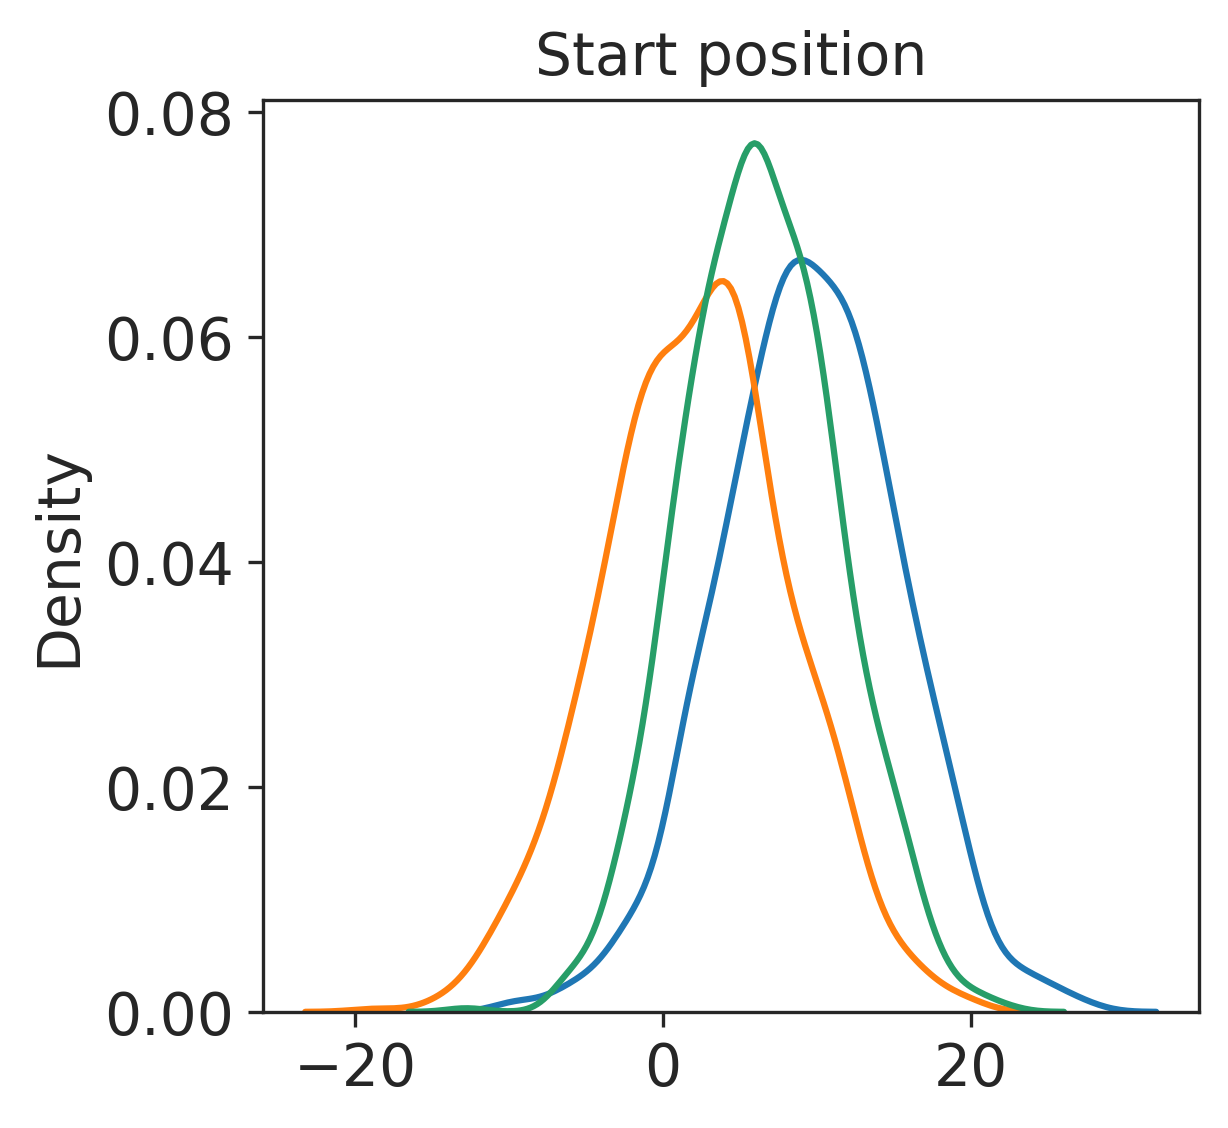

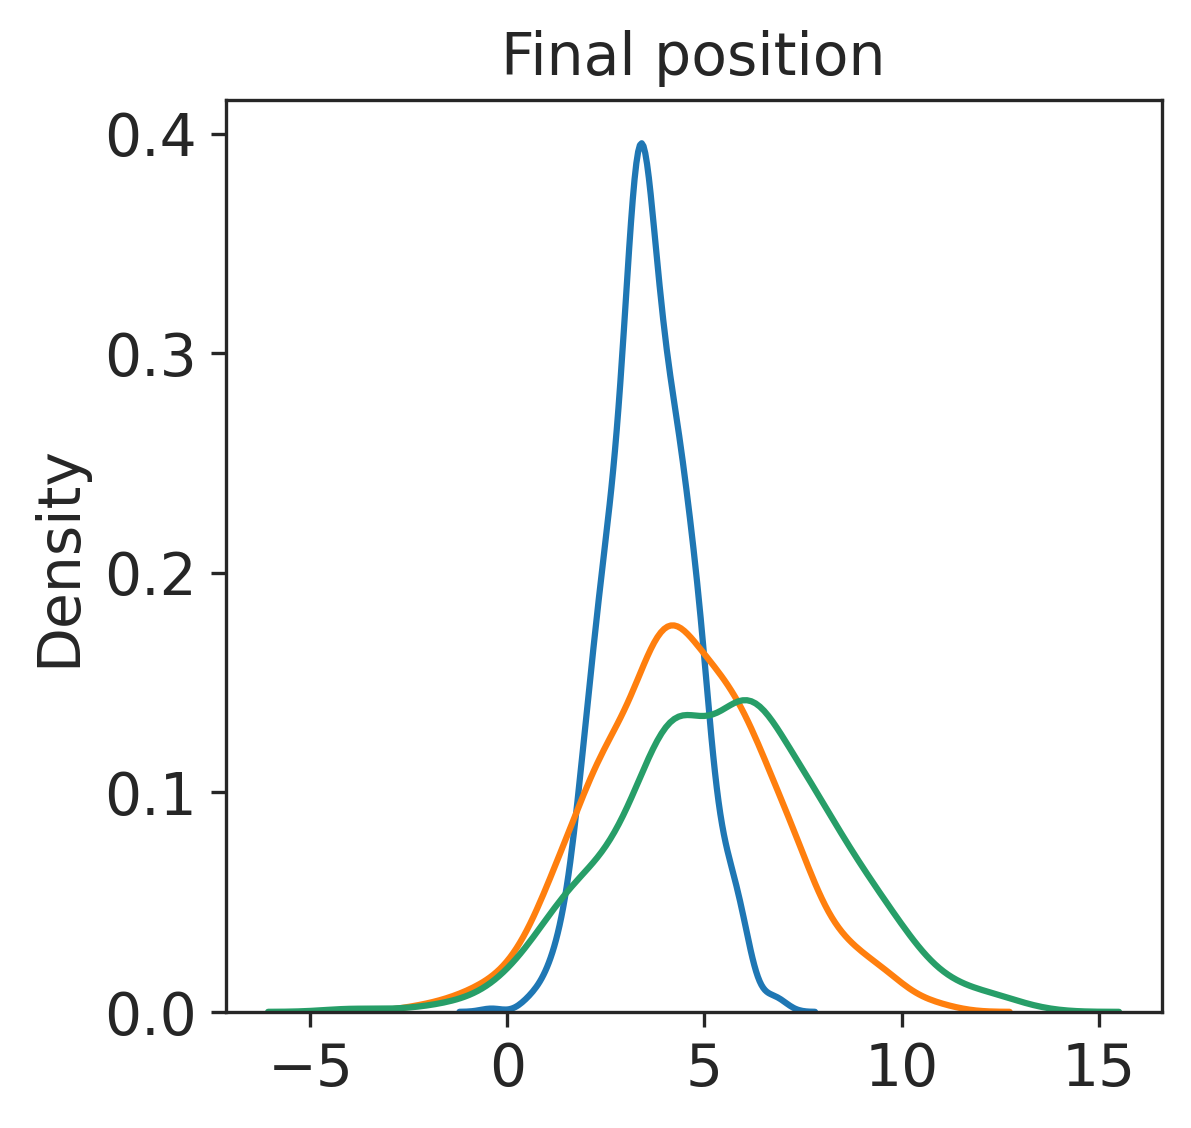

In [211]:
params = initial_params(phi_param = "std", mu = "std", sigma = "random")
pred, prob, avg_allprob, params = run_EM(X, params)
plot_final(params)

Тоже ничего хорошего

Исходя из вышепроведенных экспериментов, я могу сделать вывод: на устойчивость алгоритма влияют все параметры, которые мы изначально определяем

<h2>Задание 2</h2>

Напишите NextFlow-пайплайн, который бы включал в себя определение экспрессий при помощи `kallisto | bustools`, а потом устранение дублетов при помощи DropletUtils.

In [5]:
!cat filter_adata.nf

params.results_dir = "results/"
params.output_dir = "kb_data/"

log.info "${baseDir}"

process kb_count {
	
	output:
	  path "kb_data/"
		 
	script:
	
	  """
	  mkdir kb_data
	  kb count --h5ad -i "$baseDir/index.idx" -g "$baseDir/t2g.txt" -x 10xv2 -t2 -o kb_data/ "$baseDir/SRR8599150_S1_L001_R1_001.fastq.gz" "$baseDir/SRR8599150_S1_L001_R2_001.fastq.gz"
	  """
}

process python_script {
	publishDir "${params.results_dir}"
	
	input:
		path x
	output: 
		path "filtered_adata.h5ad"
		
	script:
		"""
		#!/usr/bin/env python
		import scanpy as sc
		import pandas as pd
		import anndata2ri
		import rpy2.robjects as ro
		import scipy.stats as stats
		anndata2ri.activate()

		adata = sc.read_h5ad("$x/" + "counts_unfiltered/adata.h5ad")

		ro.r("library(DropletUtils)")
		ro.globalenv["adata_raw"] = adata
		df = ro.r('e.out <- emptyDrops(assay(adata_raw))')

		cell_barcodes = df.loc[df.FDR < 0.05]
		adata_emptydrops = adata[cell_barcodes.index]
		adata_emptydrops.write_h5ad("filtered_adata.h5ad"

In [287]:
#kb ref -d mouse -i index.idx -g t2g.txt
# пайплайн требует предварительно скачанные fastq-файлы и индекс, t2g.txt (полученные командой выше)
!nextflow run filter_adata.nf